In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer
from sklearn.multioutput import MultiOutputRegressor

import math
import pandas as pd
import operator

from scipy import stats
import random
import copy

from scipy.stats import norm, kurtosis


from tqdm import tqdm

In [3]:
import tensorflow as tf
tf.executing_eagerly()
import keras
import keras.backend as K
from keras import layers, models, optimizers, initializers, regularizers, constraints, losses
from keras.models import Sequential, Model, load_model, Input
from keras.layers import (Dense, Concatenate, BatchNormalization, Activation, Add,
                          concatenate, Dropout, AlphaDropout, Reshape, Layer, Multiply, Lambda)
from keras.layers import (Dense, Concatenate, BatchNormalization, Activation, Add,
                          concatenate, Dropout, AlphaDropout, Reshape, Layer, Multiply)
from keras.layers import (Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, 
                          GlobalMaxPooling1D, SeparableConv1D, MaxPool1D, AveragePooling1D, 
                          SeparableConv1D, AtrousConvolution1D)
from keras.layers import (Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, 
                          GlobalMaxPooling2D, SeparableConv2D, MaxPool2D, AveragePooling2D, 
                          SeparableConv2D, AtrousConvolution2D)
from keras.layers import LSTM, GRU, Bidirectional
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.losses import binary_crossentropy,  kullback_leibler_divergence, mean_squared_error

def mish(x):
    return x*K.tanh(K.softplus(x))

def decay(epoch, steps=100):
    initial_lrate = 1e-3
    drop = 0.9
    epochs_drop = 25
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    lrate = max(lrate, 5e-5)
    return lrate

es = EarlyStopping(patience=25, restore_best_weights=True, monitor='val_total_loss')
lrs = LearningRateScheduler(decay, verbose=2)

Using TensorFlow backend.


In [4]:
def grap_year(x):
    y, _, _ = x.split('-')
    return int(y)

def grap_date(x):
    y = x[5:10].replace('-','')
    return y

def grap_hour(x):
    return x[11:13]

# def custom_loss(y_true, y_pred):
#     res = 0
#     cnt = 0
#     for i in range(0, len(y_true), 24):
#         yt = y_true[i:i+24]
#         yp = y_pred[i:i+24]
#         a = np.abs(yt-yp)
#         c = 113
#         S = np.sum(yt)
#         res += np.sum(a*yt/(S*c))
#         cnt += 1
#     return res/cnt

def custom_loss(y_true, y_pred):
    res = np.abs(y_true-y_pred)*y_true
    ans = []
    for i, s in enumerate(res):
        ans.append(s/np.sum(y_true[i]))
    return np.mean(ans)

def custom_loss_nn(y_true, y_pred):
    res = K.abs(y_true*113-y_pred*113)*y_true/K.sum(y_true)
    res = K.mean(res, axis=1)

    return K.mean(res)

class Lookahead(keras.optimizers.Optimizer):
    """The lookahead mechanism for optimizers.
    Default parameters follow those provided in the original paper.
    # Arguments
        optimizer: An existed optimizer.
        sync_period: int > 0. The synchronization period.
        slow_step: float, 0 < alpha < 1. The step size of slow weights.
    # References
        - [Lookahead Optimizer: k steps forward, 1 step back]
          (https://arxiv.org/pdf/1907.08610v1.pdf)
    """

    def __init__(self, optimizer, sync_period=5, slow_step=0.5, **kwargs):
        super(Lookahead, self).__init__(**kwargs)
        self.optimizer = keras.optimizers.get(optimizer)
        with K.name_scope(self.__class__.__name__):
            self.sync_period = K.variable(sync_period, dtype='int64', name='sync_period')
            self.slow_step = K.variable(slow_step, name='slow_step')

    @property
    def lr(self):
        return self.optimizer.lr

    @lr.setter
    def lr(self, lr):
        self.optimizer.lr = lr

    @property
    def learning_rate(self):
        return self.optimizer.learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        self.optimizer.learning_rate = learning_rate

    @property
    def iterations(self):
        return self.optimizer.iterations

    def get_updates(self, loss, params):
        sync_cond = K.equal((self.iterations + 1) // self.sync_period * self.sync_period, (self.iterations + 1))
        slow_params = {p.name: K.variable(K.get_value(p), name='sp_{}'.format(i)) for i, p in enumerate(params)}
        update_names = ['update', 'update_add', 'update_sub']
        original_updates = [getattr(K, name) for name in update_names]
        setattr(K, 'update', lambda x, new_x: ('update', x, new_x))
        setattr(K, 'update_add', lambda x, new_x: ('update_add', x, new_x))
        setattr(K, 'update_sub', lambda x, new_x: ('update_sub', x, new_x))
        self.updates = self.optimizer.get_updates(loss, params)
        for name, original_update in zip(update_names, original_updates):
            setattr(K, name, original_update)
        slow_updates = []
        for i, update in enumerate(self.updates):
            if isinstance(update, tuple):
                name, x, new_x, adjusted = update + (update[-1],)
                update_func = getattr(K, name)
                if name == 'update_add':
                    adjusted = x + new_x
                if name == 'update_sub':
                    adjusted = x - new_x
                if x.name not in slow_params:
                    self.updates[i] = update_func(x, new_x)
                else:
                    slow_param = slow_params[x.name]
                    slow_param_t = slow_param + self.slow_step * (adjusted - slow_param)
                    slow_updates.append(K.update(slow_param, K.switch(
                        sync_cond,
                        slow_param_t,
                        slow_param,
                    )))
                    self.updates[i] = K.update(x, K.switch(
                        sync_cond,
                        slow_param_t,
                        adjusted,
                    ))
        slow_params = list(slow_params.values())
        self.updates += slow_updates
        self.weights = self.optimizer.weights + slow_params
        return self.updates

    def get_config(self):
        config = {
            'optimizer': keras.optimizers.serialize(self.optimizer),
            'sync_period': int(K.get_value(self.sync_period)),
            'slow_step': float(K.get_value(self.slow_step)),
        }
        base_config = super(Lookahead, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        optimizer = keras.optimizers.deserialize(config.pop('optimizer'))
        return cls(optimizer, **config)
    
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [5]:
target = pd.read_csv('./data/SolarPV_Elec_Problem.csv', header=None)
data = pd.read_csv('./data/features3.csv')#.iloc[0:-2,:] # 자료가 21시까지
# sub = pd.read_csv('./data/제출양식_복원값.xlsx')

In [6]:
target2 = pd.read_csv('./data/Solar_PV_July.csv', header=None)

In [7]:
target['year'] = target[0].map(grap_year)
target['md'] = target[0].map(grap_date)
target['hour'] = target[0].map(grap_hour)
target = target.drop(0, axis=1)

In [8]:
target2['year'] = target2[0].map(grap_year)
target2['md'] = target2[0].map(grap_date)
target2['hour'] = target2[0].map(grap_hour)
target2 = target2.drop(0, axis=1)

In [9]:
target = target.fillna(-10)
y = target.groupby(['year', 'md', 'hour']).sum()[1].values[:8760]

In [10]:
y2 = target2.groupby(['year', 'md', 'hour']).sum()[1].values
y2 = np.hstack([y2, [0, 0]])

In [11]:
steps = 24
tr_X = []
tr_y = []
val_X = []
val_y = []

y1 = y[:5136]
for i in range(steps, len(y1)+1, 24):
    tr_X.append(y1[i-steps:i])
    tr_y.append(y1[i:i+24])
    
tr_X = tr_X[:-1]
tr_y = tr_y[:-1]
val_X.append(tr_X[-1])
val_y.append(tr_y[-1])
tr_X.pop(-1)
tr_y.pop(-1)
    
    
y1 = y[5160:6576]
for i in range(steps, len(y1)+1, 24):
    tr_X.append(y1[i-steps:i])
    tr_y.append(y1[i:i+24])
    
tr_X = tr_X[:-1]
tr_y = tr_y[:-1]
val_X.append(tr_X[-1])
val_y.append(tr_y[-1])
tr_X.pop(-1)
tr_y.pop(-1)
    
    
y1 = y[6600:8040]
for i in range(steps, len(y1)+1, 24):
    tr_X.append(y1[i-steps:i])
    tr_y.append(y1[i:i+24])
    
tr_X = tr_X[:-1]
tr_y = tr_y[:-1]
val_X.append(tr_X[-1])
val_y.append(tr_y[-1])
tr_X.pop(-1)
tr_y.pop(-1)
    
    
y1 = y[8064:8760]
for i in range(steps, len(y1)+1, 24):
    tr_X.append(y1[i-steps:i])
    tr_y.append(y1[i:i+24])
    
tr_X = tr_X[:-1]
tr_y = tr_y[:-1]

In [12]:
steps = 24
y1 = y2.copy()
for i in range(steps, len(y1)+1, 24):
    tr_X.append(y1[i-steps:i])
    tr_y.append(y1[i:i+24])
    
te_X = tr_X[-1]
tr_X = tr_X[:-1]
tr_y = tr_y[:-1]

val_X.append(tr_X[-1])
val_y.append(tr_y[-1])
tr_X.pop(-1)
tr_y.pop(-1)

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 5.0000e-03, 4.2100e-01, 4.0770e+00, 7.5910e+00,
       6.5240e+00, 1.0965e+01, 1.4411e+01, 1.1109e+01, 1.6948e+01,
       1.5657e+01, 1.0954e+01, 6.0110e+00, 2.5490e+00, 4.6900e-01,
       8.0000e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00])

In [13]:
tr_X = np.array(tr_X)
tr_y = np.array(tr_y)
val_X = np.array(val_X)[:-1]
val_y = np.array(val_y)[:-1]

In [14]:
tr_X.shape, tr_y.shape, val_X.shape, val_y.shape

((382, 24), (382, 24), (3, 24), (3, 24))

In [15]:
def wave_block(filters,kernel_size,n):
    def f(x):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters=filters,
                    kernel_size=1, 
                    padding='same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters=filters,
                    kernel_size=kernel_size, 
                    padding='same',
                    activation = 'tanh',
                    dilation_rate=dilation_rate)(x)
            sigm_out = Conv1D(filters=filters,
                    kernel_size=kernel_size, 
                    padding='same',
                    activation = 'sigmoid',
                    dilation_rate=dilation_rate)(x)
            x = Multiply()([tanh_out,sigm_out])
            x = Conv1D(filters = filters,
                           kernel_size = 1,
                           padding='same')(x)
            # x = BatchNormalization()(x)
    #             x = SpatialDropout1D(0.2)(x)
            res_x = Add()([res_x,x])
        return res_x
    return f

def conv1d_block(x, fs, ks, activation=None):
    x = Conv1D(fs, ks, padding='same', kernel_initializer='he_normal')(x)
    x = Activation(activation)(x)
    return x

In [16]:
def build_flat():
    inputs = Input(shape = ttr_X.shape[1:])
    x1 = conv1d_block(inputs, 16, 2, mish)
    x1 = MaxPooling1D(2)(x1)
    x1 = conv1d_block(x1, 32, 2, mish)
    x1 = MaxPooling1D(2)(x1)
    x1 = Bidirectional(LSTM(32, return_sequences=True))(x1)
    x1 = Flatten()(x1)
    # x1 = Attention(24)(x1)

    x1_out = Dense(512, kernel_initializer='he_normal')(x1)
    x1_out = Activation(mish)(x1_out)
    x1_out = Dense(256, kernel_initializer='he_normal')(x1_out)
    x1_out = Activation(mish)(x1_out)
    x1_out = Dense(128, kernel_initializer='he_normal')(x1_out)
    x1_out = Activation(mish)(x1_out)
    x1_out = Dense(1, kernel_initializer='he_normal')(x1_out)

    x2 = conv1d_block(inputs, 16, 3, mish)
    x2 = MaxPooling1D(2)(x2)
    x2 = conv1d_block(x2, 32, 3, mish)
    x2 = MaxPooling1D(2)(x2)
    x2 = Bidirectional(LSTM(32, return_sequences=True))(x2)
    x2 = Flatten()(x2)
    # x2 = Attention(24)(x2)

    x2_out = Dense(512, kernel_initializer='he_normal')(x2)
    x2_out = Activation(mish)(x2_out)
    x2_out = Dense(256, kernel_initializer='he_normal')(x2_out)
    x2_out = Activation(mish)(x2_out)
    x2_out = Dense(128, kernel_initializer='he_normal')(x2_out)
    x2_out = Activation(mish)(x2_out)
    x2_out = Dense(24)(x2_out)

    x3 = conv1d_block(inputs, 16, 5, mish)
    x3 = MaxPooling1D(2)(x3)
    x3 = conv1d_block(x3, 32, 5, mish)
    x3 = MaxPooling1D(2)(x3)
    x3 = Bidirectional(LSTM(32, return_sequences=True))(x3)
    x3 = Flatten()(x3)
    # x3 = Attention(24)(x3)

    x3_out = Dense(512, kernel_initializer='he_normal')(x3)
    x3_out = Activation(mish)(x3_out)
    x3_out = Dense(256, kernel_initializer='he_normal')(x3_out)
    x3_out = Activation(mish)(x3_out)
    x3_out = Dense(128, kernel_initializer='he_normal')(x3_out)
    x3_out = Activation(mish)(x3_out)
    x3_out = Dense(24)(x3_out)

    x4 = conv1d_block(inputs, 16, 7, mish)
    x4 = MaxPooling1D(2)(x4)
    x4 = conv1d_block(x4, 32, 7, mish)
    x4 = MaxPooling1D(2)(x4)
    x4 = Bidirectional(LSTM(32, return_sequences=True))(x4)
    x4 = Flatten()(x4)
    # x4 = Attention(24)(x4)

    x4_out = Dense(512, kernel_initializer='he_normal')(x4)
    x4_out = Activation(mish)(x4_out)
    x4_out = Dense(256, kernel_initializer='he_normal')(x4_out)
    x4_out = Activation(mish)(x4_out)
    x4_out = Dense(128, kernel_initializer='he_normal')(x4_out)
    x4_out = Activation(mish)(x4_out)
    x4_out = Dense(24)(x4_out)

    x = Add()([x1, x2, x3, x4])
    x = Dense(512, kernel_initializer='he_normal')(x)
    x = Activation(mish)(x)
    x = Dense(256, kernel_initializer='he_normal')(x)
    x = Activation(mish)(x)
    x = Dense(128, kernel_initializer='he_normal')(x)
    x = Activation(mish)(x)
    x = Dense(24)(x)

    nn = Model(inputs, [x, x1_out,x2_out,x3_out, x4_out])
    return nn


def build_att():
    inputs = Input(shape = ttr_X.shape[1:])
    x1 = conv1d_block(inputs, 16, 2, mish)
    x1 = MaxPooling1D(2)(x1)
    x1 = conv1d_block(x1, 32, 2, mish)
    x1 = MaxPooling1D(2)(x1)
    x1 = Bidirectional(LSTM(32, return_sequences=True))(x1)
#     x1 = Flatten()(x1)
    x1 = Attention(6)(x1)

    x1_out = Dense(512, kernel_initializer='he_normal')(x1)
    x1_out = Activation(mish)(x1_out)
    x1_out = Dense(256, kernel_initializer='he_normal')(x1_out)
    x1_out = Activation(mish)(x1_out)
    x1_out = Dense(128, kernel_initializer='he_normal')(x1_out)
    x1_out = Activation(mish)(x1_out)
    x1_out = Dense(24, kernel_initializer='he_normal')(x1_out)

    x2 = conv1d_block(inputs, 16, 3, mish)
    x2 = MaxPooling1D(2)(x2)
    x2 = conv1d_block(x2, 32, 3, mish)
    x2 = MaxPooling1D(2)(x2)
    x2 = Bidirectional(LSTM(32, return_sequences=True))(x2)
#     x2 = Flatten()(x2)
    x2 = Attention(6)(x2)

    x2_out = Dense(64, kernel_initializer='he_normal')(x2)
    x2_out = Activation(mish)(x2_out)
    x2_out = Dense(32, kernel_initializer='he_normal')(x2_out)
    x2_out = Activation(mish)(x2_out)
#     x2_out = Dense(128, kernel_initializer='he_normal')(x2_out)
#     x2_out = Activation(mish)(x2_out)
    x2_out = Dense(24)(x2_out)

    x3 = conv1d_block(inputs, 16, 5, mish)
    x3 = MaxPooling1D(2)(x3)
    x3 = conv1d_block(x3, 32, 5, mish)
    x3 = MaxPooling1D(2)(x3)
    x3 = Bidirectional(LSTM(32, return_sequences=True))(x3)
#     x3 = Flatten()(x3)
    x3 = Attention(6)(x3)

    x3_out = Dense(64, kernel_initializer='he_normal')(x3)
    x3_out = Activation(mish)(x3_out)
    x3_out = Dense(32, kernel_initializer='he_normal')(x3_out)
    x3_out = Activation(mish)(x3_out)
#     x3_out = Dense(128, kernel_initializer='he_normal')(x3_out)
#     x3_out = Activation(mish)(x3_out)
    x3_out = Dense(24)(x3_out)

    x4 = conv1d_block(inputs, 16, 7, mish)
    x4 = MaxPooling1D(2)(x4)
    x4 = conv1d_block(x4, 32, 7, mish)
    x4 = MaxPooling1D(2)(x4)
    x4 = Bidirectional(LSTM(32, return_sequences=True))(x4)
#     x4 = Flatten()(x4)
    x4 = Attention(6)(x4)

    x4_out = Dense(64, kernel_initializer='he_normal')(x4)
    x4_out = Activation(mish)(x4_out)
    x4_out = Dense(32, kernel_initializer='he_normal')(x4_out)
    x4_out = Activation(mish)(x4_out)
#     x4_out = Dense(128, kernel_initializer='he_normal')(x4_out)
#     x4_out = Activation(mish)(x4_out)
    x4_out = Dense(24)(x4_out)

    x = Add()([x1, x2, x3, x4])
    x = Dense(64, kernel_initializer='he_normal')(x)
    x = Activation(mish)(x)
    x = Dense(32, kernel_initializer='he_normal')(x)
    x = Activation(mish)(x)
#     x = Dense(128, kernel_initializer='he_normal')(x)
#     x = Activation(mish)(x)
    x = Dense(24)(x)

    nn = Model(inputs, [x, x1_out,x2_out,x3_out, x4_out])
    return nn

def build_wav():
    inputs = Input(shape = ttr_X.shape[1:])
    x1 = wave_block(16, 3, 5)(inputs)
    x1 = MaxPooling1D(2)(x1)
    x1 = wave_block(32, 3, 3)(x1)
    x1 = MaxPooling1D(2)(x1)
    x1 = Bidirectional(LSTM(32, return_sequences=True))(x1)
    x1 = Attention(6)(x1)

    x = Dense(64, kernel_initializer='he_normal')(x1)
    x = Activation(mish)(x)
#     x = Dense(32, kernel_initializer='he_normal')(x)
#     x = Activation(mish)(x)
#     x = Dense(128, kernel_initializer='he_normal')(x)
#     x = Activation(mish)(x)
    x = Dense(24)(x)

    nn = Model(inputs, x)
    return nn

In [18]:
ttr_X = np.expand_dims(tr_X, -1)
ttr_X.shape

(382, 24, 1)

In [36]:
nn = build_att()
nn.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 24, 1)        0                                            
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 24, 16)       48          input_3[0][0]                    
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 24, 16)       0           conv1d_35[0][0]                  
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 24, 16)       64          input_3[0][0]                    
____________________________________________________________________________________________

In [37]:
nn.compile(loss=custom_loss_nn, optimizer='adam')
nn.fit(ttr_X/113, [tr_y/113]*5, # [tr_y/113]*5
      epochs=200,
       validation_split=0.2,
#        batch_size=32,
       shuffle=True,
      callbacks=[es, lrs])

Train on 305 samples, validate on 77 samples
Epoch 1/200

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
305/305 [==============================] - 5s 16ms/step - loss: 0.3004 - dense_34_loss: 0.0631 - dense_22_loss: 0.0416 - dense_25_loss: 0.0628 - dense_28_loss: 0.0691 - dense_31_loss: 0.0677 - val_loss: 0.2277 - val_dense_34_loss: 0.0518 - val_dense_22_loss: 0.0351 - val_dense_25_loss: 0.0530 - val_dense_28_loss: 0.0601 - val_dense_31_loss: 0.0559
Epoch 2/200

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
305/305 [==============================] - 1s 4ms/step - loss: 0.1638 - dense_34_loss: 0.0335 - dense_22_loss: 0.0249 - dense_25_loss: 0.0366 - dense_28_loss: 0.0376 - dense_31_loss: 0.0331 - val_loss: 0.1533 - val_dense_34_loss: 0.0406 - val_dense_22_loss: 0.0320 - val_dense_25_loss: 0.0389 - val_dense_28_loss: 0.0359 - val_dense_31_loss: 0.0335
Epoch 3/200

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
305/305 [=======

Epoch 20/200

Epoch 00020: LearningRateScheduler setting learning rate to 0.001.
305/305 [==============================] - 1s 4ms/step - loss: 0.0882 - dense_34_loss: 0.0180 - dense_22_loss: 0.0186 - dense_25_loss: 0.0183 - dense_28_loss: 0.0182 - dense_31_loss: 0.0181 - val_loss: 0.1139 - val_dense_34_loss: 0.0293 - val_dense_22_loss: 0.0286 - val_dense_25_loss: 0.0295 - val_dense_28_loss: 0.0285 - val_dense_31_loss: 0.0296
Epoch 21/200

Epoch 00021: LearningRateScheduler setting learning rate to 0.001.
305/305 [==============================] - 1s 4ms/step - loss: 0.0885 - dense_34_loss: 0.0186 - dense_22_loss: 0.0186 - dense_25_loss: 0.0189 - dense_28_loss: 0.0191 - dense_31_loss: 0.0189 - val_loss: 0.1154 - val_dense_34_loss: 0.0297 - val_dense_22_loss: 0.0281 - val_dense_25_loss: 0.0295 - val_dense_28_loss: 0.0290 - val_dense_31_loss: 0.0302
Epoch 22/200

Epoch 00022: LearningRateScheduler setting learning rate to 0.001.
305/305 [==============================] - 1s 4ms/step - lo

305/305 [==============================] - 1s 4ms/step - loss: 0.0839 - dense_34_loss: 0.0171 - dense_22_loss: 0.0177 - dense_25_loss: 0.0175 - dense_28_loss: 0.0176 - dense_31_loss: 0.0173 - val_loss: 0.1146 - val_dense_34_loss: 0.0294 - val_dense_22_loss: 0.0290 - val_dense_25_loss: 0.0297 - val_dense_28_loss: 0.0292 - val_dense_31_loss: 0.0296
Epoch 39/200

Epoch 00039: LearningRateScheduler setting learning rate to 0.0009000000000000001.
305/305 [==============================] - 1s 3ms/step - loss: 0.0833 - dense_34_loss: 0.0169 - dense_22_loss: 0.0173 - dense_25_loss: 0.0172 - dense_28_loss: 0.0173 - dense_31_loss: 0.0171 - val_loss: 0.1127 - val_dense_34_loss: 0.0283 - val_dense_22_loss: 0.0288 - val_dense_25_loss: 0.0287 - val_dense_28_loss: 0.0283 - val_dense_31_loss: 0.0283
Epoch 40/200

Epoch 00040: LearningRateScheduler setting learning rate to 0.0009000000000000001.
305/305 [==============================] - 1s 4ms/step - loss: 0.0827 - dense_34_loss: 0.0170 - dense_22_los

305/305 [==============================] - 1s 3ms/step - loss: 0.0819 - dense_34_loss: 0.0167 - dense_22_loss: 0.0170 - dense_25_loss: 0.0170 - dense_28_loss: 0.0169 - dense_31_loss: 0.0169 - val_loss: 0.1126 - val_dense_34_loss: 0.0284 - val_dense_22_loss: 0.0289 - val_dense_25_loss: 0.0288 - val_dense_28_loss: 0.0286 - val_dense_31_loss: 0.0286
Epoch 57/200

Epoch 00057: LearningRateScheduler setting learning rate to 0.0008100000000000001.
305/305 [==============================] - 1s 4ms/step - loss: 0.0813 - dense_34_loss: 0.0166 - dense_22_loss: 0.0169 - dense_25_loss: 0.0170 - dense_28_loss: 0.0168 - dense_31_loss: 0.0167 - val_loss: 0.1136 - val_dense_34_loss: 0.0287 - val_dense_22_loss: 0.0298 - val_dense_25_loss: 0.0290 - val_dense_28_loss: 0.0286 - val_dense_31_loss: 0.0286
Epoch 58/200

Epoch 00058: LearningRateScheduler setting learning rate to 0.0008100000000000001.
305/305 [==============================] - 1s 4ms/step - loss: 0.0815 - dense_34_loss: 0.0166 - dense_22_los

305/305 [==============================] - 1s 3ms/step - loss: 0.0829 - dense_34_loss: 0.0173 - dense_22_loss: 0.0176 - dense_25_loss: 0.0174 - dense_28_loss: 0.0175 - dense_31_loss: 0.0173 - val_loss: 0.1138 - val_dense_34_loss: 0.0290 - val_dense_22_loss: 0.0289 - val_dense_25_loss: 0.0296 - val_dense_28_loss: 0.0290 - val_dense_31_loss: 0.0293
Epoch 75/200

Epoch 00075: LearningRateScheduler setting learning rate to 0.0007290000000000002.
305/305 [==============================] - 1s 3ms/step - loss: 0.0823 - dense_34_loss: 0.0170 - dense_22_loss: 0.0172 - dense_25_loss: 0.0173 - dense_28_loss: 0.0172 - dense_31_loss: 0.0171 - val_loss: 0.1131 - val_dense_34_loss: 0.0289 - val_dense_22_loss: 0.0290 - val_dense_25_loss: 0.0292 - val_dense_28_loss: 0.0295 - val_dense_31_loss: 0.0290
Epoch 76/200

Epoch 00076: LearningRateScheduler setting learning rate to 0.0007290000000000002.
305/305 [==============================] - 1s 3ms/step - loss: 0.0824 - dense_34_loss: 0.0174 - dense_22_los

305/305 [==============================] - 1s 4ms/step - loss: 0.0833 - dense_34_loss: 0.0173 - dense_22_loss: 0.0180 - dense_25_loss: 0.0171 - dense_28_loss: 0.0178 - dense_31_loss: 0.0173 - val_loss: 0.1122 - val_dense_34_loss: 0.0282 - val_dense_22_loss: 0.0284 - val_dense_25_loss: 0.0287 - val_dense_28_loss: 0.0286 - val_dense_31_loss: 0.0283
Epoch 93/200

Epoch 00093: LearningRateScheduler setting learning rate to 0.0007290000000000002.
305/305 [==============================] - 1s 3ms/step - loss: 0.0824 - dense_34_loss: 0.0168 - dense_22_loss: 0.0174 - dense_25_loss: 0.0167 - dense_28_loss: 0.0170 - dense_31_loss: 0.0169 - val_loss: 0.1156 - val_dense_34_loss: 0.0286 - val_dense_22_loss: 0.0291 - val_dense_25_loss: 0.0288 - val_dense_28_loss: 0.0289 - val_dense_31_loss: 0.0285
Epoch 94/200

Epoch 00094: LearningRateScheduler setting learning rate to 0.0007290000000000002.
305/305 [==============================] - 1s 3ms/step - loss: 0.0836 - dense_34_loss: 0.0171 - dense_22_los

305/305 [==============================] - 1s 4ms/step - loss: 0.0789 - dense_34_loss: 0.0157 - dense_22_loss: 0.0161 - dense_25_loss: 0.0161 - dense_28_loss: 0.0158 - dense_31_loss: 0.0161 - val_loss: 0.1126 - val_dense_34_loss: 0.0286 - val_dense_22_loss: 0.0291 - val_dense_25_loss: 0.0290 - val_dense_28_loss: 0.0291 - val_dense_31_loss: 0.0290
Epoch 111/200

Epoch 00111: LearningRateScheduler setting learning rate to 0.0006561000000000001.
305/305 [==============================] - 1s 3ms/step - loss: 0.0811 - dense_34_loss: 0.0169 - dense_22_loss: 0.0173 - dense_25_loss: 0.0172 - dense_28_loss: 0.0169 - dense_31_loss: 0.0170 - val_loss: 0.1125 - val_dense_34_loss: 0.0285 - val_dense_22_loss: 0.0294 - val_dense_25_loss: 0.0288 - val_dense_28_loss: 0.0285 - val_dense_31_loss: 0.0284
Epoch 112/200

Epoch 00112: LearningRateScheduler setting learning rate to 0.0006561000000000001.
305/305 [==============================] - 1s 4ms/step - loss: 0.0797 - dense_34_loss: 0.0165 - dense_22_l

Epoch 129/200

Epoch 00129: LearningRateScheduler setting learning rate to 0.00059049.
305/305 [==============================] - 1s 4ms/step - loss: 0.0789 - dense_34_loss: 0.0162 - dense_22_loss: 0.0165 - dense_25_loss: 0.0164 - dense_28_loss: 0.0163 - dense_31_loss: 0.0164 - val_loss: 0.1114 - val_dense_34_loss: 0.0283 - val_dense_22_loss: 0.0282 - val_dense_25_loss: 0.0285 - val_dense_28_loss: 0.0288 - val_dense_31_loss: 0.0285
Epoch 130/200

Epoch 00130: LearningRateScheduler setting learning rate to 0.00059049.
305/305 [==============================] - 1s 4ms/step - loss: 0.0797 - dense_34_loss: 0.0163 - dense_22_loss: 0.0167 - dense_25_loss: 0.0168 - dense_28_loss: 0.0164 - dense_31_loss: 0.0164 - val_loss: 0.1126 - val_dense_34_loss: 0.0285 - val_dense_22_loss: 0.0286 - val_dense_25_loss: 0.0288 - val_dense_28_loss: 0.0288 - val_dense_31_loss: 0.0285
Epoch 131/200

Epoch 00131: LearningRateScheduler setting learning rate to 0.00059049.
305/305 [==============================] 

Epoch 148/200

Epoch 00148: LearningRateScheduler setting learning rate to 0.00059049.
305/305 [==============================] - 1s 4ms/step - loss: 0.0790 - dense_34_loss: 0.0161 - dense_22_loss: 0.0169 - dense_25_loss: 0.0164 - dense_28_loss: 0.0163 - dense_31_loss: 0.0161 - val_loss: 0.1158 - val_dense_34_loss: 0.0299 - val_dense_22_loss: 0.0293 - val_dense_25_loss: 0.0297 - val_dense_28_loss: 0.0300 - val_dense_31_loss: 0.0304
Epoch 149/200

Epoch 00149: LearningRateScheduler setting learning rate to 0.00059049.
305/305 [==============================] - 1s 4ms/step - loss: 0.0828 - dense_34_loss: 0.0173 - dense_22_loss: 0.0174 - dense_25_loss: 0.0172 - dense_28_loss: 0.0174 - dense_31_loss: 0.0172 - val_loss: 0.1129 - val_dense_34_loss: 0.0282 - val_dense_22_loss: 0.0280 - val_dense_25_loss: 0.0287 - val_dense_28_loss: 0.0288 - val_dense_31_loss: 0.0281
Epoch 150/200

Epoch 00150: LearningRateScheduler setting learning rate to 0.000531441.
305/305 [==============================]

Epoch 167/200

Epoch 00167: LearningRateScheduler setting learning rate to 0.000531441.
305/305 [==============================] - 1s 4ms/step - loss: 0.0777 - dense_34_loss: 0.0158 - dense_22_loss: 0.0163 - dense_25_loss: 0.0164 - dense_28_loss: 0.0160 - dense_31_loss: 0.0160 - val_loss: 0.1134 - val_dense_34_loss: 0.0290 - val_dense_22_loss: 0.0286 - val_dense_25_loss: 0.0296 - val_dense_28_loss: 0.0293 - val_dense_31_loss: 0.0289
Epoch 168/200

Epoch 00168: LearningRateScheduler setting learning rate to 0.000531441.
305/305 [==============================] - 1s 3ms/step - loss: 0.0774 - dense_34_loss: 0.0154 - dense_22_loss: 0.0161 - dense_25_loss: 0.0163 - dense_28_loss: 0.0156 - dense_31_loss: 0.0157 - val_loss: 0.1141 - val_dense_34_loss: 0.0290 - val_dense_22_loss: 0.0295 - val_dense_25_loss: 0.0293 - val_dense_28_loss: 0.0295 - val_dense_31_loss: 0.0291
Epoch 169/200

Epoch 00169: LearningRateScheduler setting learning rate to 0.000531441.
305/305 [=============================

305/305 [==============================] - 1s 3ms/step - loss: 0.0765 - dense_34_loss: 0.0153 - dense_22_loss: 0.0161 - dense_25_loss: 0.0159 - dense_28_loss: 0.0154 - dense_31_loss: 0.0155 - val_loss: 0.1144 - val_dense_34_loss: 0.0293 - val_dense_22_loss: 0.0295 - val_dense_25_loss: 0.0302 - val_dense_28_loss: 0.0297 - val_dense_31_loss: 0.0295
Epoch 186/200

Epoch 00186: LearningRateScheduler setting learning rate to 0.0004782969000000001.
305/305 [==============================] - 1s 3ms/step - loss: 0.0772 - dense_34_loss: 0.0157 - dense_22_loss: 0.0163 - dense_25_loss: 0.0164 - dense_28_loss: 0.0161 - dense_31_loss: 0.0160 - val_loss: 0.1141 - val_dense_34_loss: 0.0290 - val_dense_22_loss: 0.0284 - val_dense_25_loss: 0.0297 - val_dense_28_loss: 0.0299 - val_dense_31_loss: 0.0294
Epoch 187/200

Epoch 00187: LearningRateScheduler setting learning rate to 0.0004782969000000001.
305/305 [==============================] - 1s 4ms/step - loss: 0.0762 - dense_34_loss: 0.0151 - dense_22_l

In [34]:
custom_loss(val_y, np.clip((nn.predict(np.expand_dims(val_X/113, -1)))*113, 0, 113))

0.4342179938250385

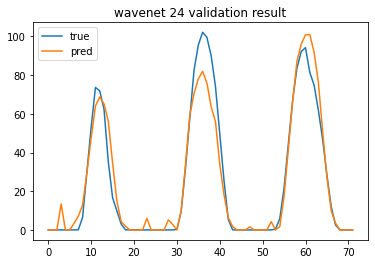

In [35]:
plt.plot(val_y.flatten(), label='true')
plt.plot(np.clip((nn.predict(np.expand_dims(val_X/113, -1))).flatten()*113, 0, 113), label='pred')
plt.title('wavenet 24 validation result')
plt.legend()
plt.show()

In [38]:
custom_loss(val_y, np.clip((nn.predict(np.expand_dims(val_X/113, -1)))[0]*113, 0, 113))

0.22744075931453203

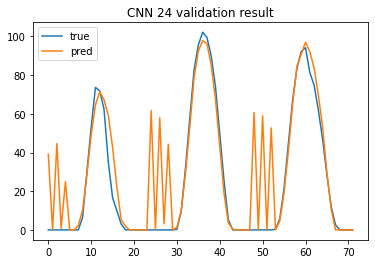

In [39]:
plt.plot(val_y.flatten(), label='true')
plt.plot(np.clip((nn.predict(np.expand_dims(val_X/113, -1)))[0].flatten()*113, 0, 113), label='pred')
plt.title('CNN 24 validation result')
plt.legend()
plt.show()